# Libraries set-up

In [3]:
pip install mesa==1.2.1

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --pre mesa[viz]

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip show mesa

Name: Mesa
Version: 1.2.1
Summary: Agent-based modeling (ABM) in Python 3+
Home-page: https://github.com/projectmesa/mesa
Author: Project Mesa Team
Author-email: projectmesa@googlegroups.com
License: Apache 2.0
Location: C:\Users\Legion\anaconda3\Lib\site-packages
Requires: click, cookiecutter, networkx, numpy, pandas, tornado, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# Importing Libraries

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import mesa 
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# Defining Model

In [9]:
class PersonAgent(Agent):
    def __init__(self, unique_id, model, state="S"):
        super().__init__(unique_id, model)
        self.state = state
        self.infected_time = 0

    def step(self):
        if self.state == "I":
            # Infect neighbors first
            neighbors = self.model.grid.get_neighbors(
                self.pos, moore=True, include_center=False)
            for neighbor in neighbors:
                if neighbor.state == "S" and self.random.random() < self.model.infection_chance:
                    neighbor.state = "I"
    
            # Then increment infection duration
            self.infected_time += 1
            if self.infected_time >= self.model.recovery_time:
                self.state = "R"
    
        # Random movement
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        new_pos = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_pos)


In [10]:
class InfectionModel(Model):
    def __init__(self, N=100, width=20, height=20, infection_chance=0.2, recovery_time=10):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, torus=True)
        self.schedule = RandomActivation(self)
        self.infection_chance = infection_chance
        self.recovery_time = recovery_time

        # Create agents
        for i in range(self.num_agents):
            state = "I" if i == 0 else "S"  # One infected, rest susceptible
            agent = PersonAgent(i, self, state)
            self.schedule.add(agent)
            x = self.random.randrange(width)
            y = self.random.randrange(height)
            self.grid.place_agent(agent, (x, y))

        self.datacollector = DataCollector(
            {
                "Susceptible": lambda m: self.count_state("S"),
                "Infected": lambda m: self.count_state("I"),
                "Recovered": lambda m: self.count_state("R"),
            }
        )

    def count_state(self, state):
        return sum(1 for a in self.schedule.agents if a.state == state)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Model Initialization

In [12]:
model = InfectionModel(N=100)

# Visualizing the Model

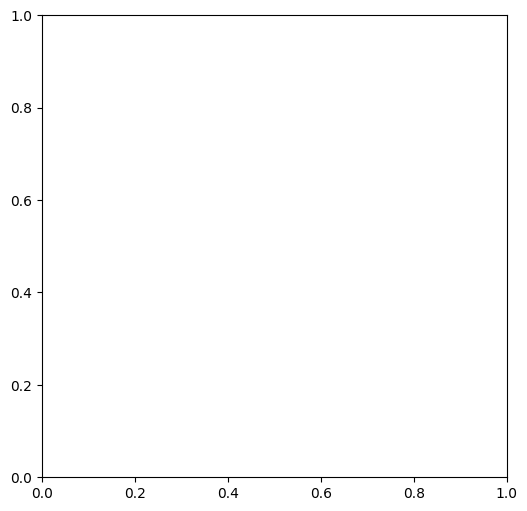

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

colors = {"S": "blue", "I": "red", "R": "green"}

def update(frame):
    ax.clear()
    model.step()
    agent_positions = [(agent.pos[0], agent.pos[1], colors[agent.state])
                       for agent in model.schedule.agents]
    
    for x, y, c in agent_positions:
        ax.scatter(x, y, color=c, s=40)
    ax.set_title(f"Step {frame}")
    ax.set_xlim(0, model.grid.width)
    ax.set_ylim(0, model.grid.height)
    ax.set_xticks([])
    ax.set_yticks([])

ani = animation.FuncAnimation(fig, update, frames=20, repeat=False)
plt.show()

In [15]:
ani.save("infection_sim2.gif", writer="pillow", fps=1)

In [16]:
for agent in model.schedule.agents:
        print(f"Agent {agent.unique_id} is in state {agent.state}")

Agent 0 is in state R
Agent 1 is in state S
Agent 2 is in state R
Agent 3 is in state I
Agent 4 is in state R
Agent 5 is in state I
Agent 6 is in state I
Agent 7 is in state R
Agent 8 is in state I
Agent 9 is in state I
Agent 10 is in state S
Agent 11 is in state S
Agent 12 is in state S
Agent 13 is in state I
Agent 14 is in state I
Agent 15 is in state R
Agent 16 is in state I
Agent 17 is in state I
Agent 18 is in state I
Agent 19 is in state I
Agent 20 is in state I
Agent 21 is in state S
Agent 22 is in state R
Agent 23 is in state R
Agent 24 is in state I
Agent 25 is in state I
Agent 26 is in state I
Agent 27 is in state S
Agent 28 is in state I
Agent 29 is in state R
Agent 30 is in state S
Agent 31 is in state R
Agent 32 is in state S
Agent 33 is in state R
Agent 34 is in state I
Agent 35 is in state I
Agent 36 is in state R
Agent 37 is in state S
Agent 38 is in state R
Agent 39 is in state I
Agent 40 is in state I
Agent 41 is in state R
Agent 42 is in state I
Agent 43 is in state 

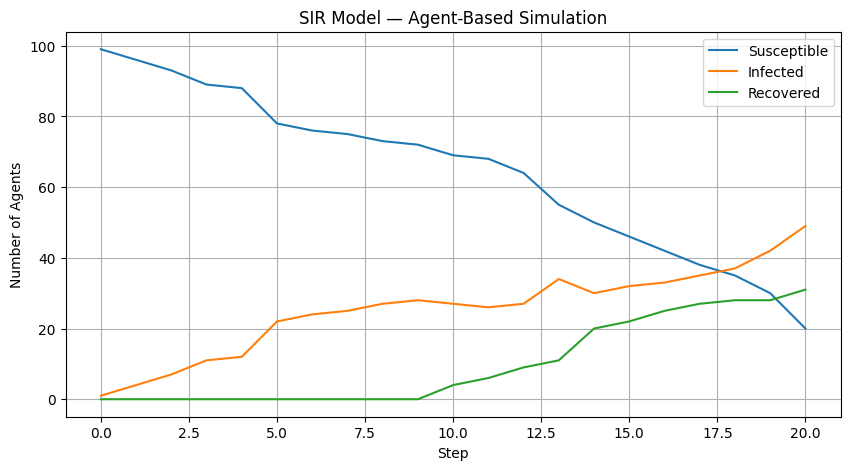

In [17]:
import matplotlib.pyplot as plt

results = model.datacollector.get_model_vars_dataframe()
results.plot(figsize=(10, 5), title="SIR Model — Agent-Based Simulation")
plt.xlabel("Step")
plt.ylabel("Number of Agents")
plt.grid(True)
plt.show()

In [18]:
print("Initial state counts:")
print("S:", model.count_state("S"))
print("I:", model.count_state("I"))
print("R:", model.count_state("R"))

Initial state counts:
S: 17
I: 48
R: 35
